In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH='/data/dogscats/'
arch=resnet34
sz=224
bs=64

In [4]:
tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip(), max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, bs, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, ps=0.5, precompute=True)

# Find learning rate

In [5]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▉  | 286/360 [00:01<00:00, 189.45it/s, loss=0.505]


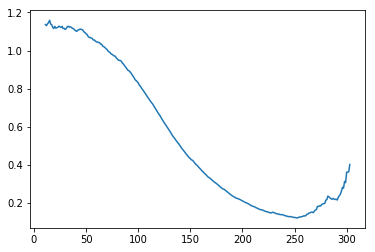

In [6]:
learn.sched.plot_loss()

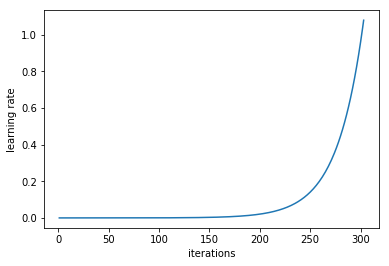

In [7]:
learn.sched.plot_lr()

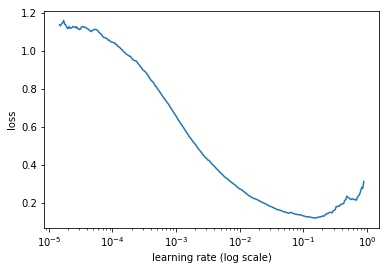

In [8]:
learn.sched.plot()

Use 10e-2 as learning rate

# Start training with last layers

In [9]:
lr = 1e-2

In [10]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.052455   0.025387   0.988281  



[0.02538689, 0.98828125]

If Train loss < validation loss ---> Overfitting likely

In [11]:
learn.precompute=False

Train without earlier layers activations unlocked, for data augmentation

In [12]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.054838   0.02617    0.989258  
    1      0.045616   0.027439   0.98877                      
    2      0.050599   0.025919   0.98877                      



[0.025918592, 0.98876953125]

Sharpen edges by unfreezing all layers. However, earlier layers need to have lower learnign rates

In [13]:
learn.unfreeze()

In [14]:
lr_a = np.array([lr/9, lr/3, lr])

In [15]:
learn.fit(lr_a, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.045797   0.02481    0.990723  
    1      0.037476   0.020816   0.993164                     
    2      0.016559   0.019962   0.993164                     
    3      0.0285     0.019327   0.993652                     
    4      0.014719   0.017714   0.994141                     
    5      0.014577   0.01814    0.994629                     
    6      0.008621   0.018414   0.994629                      



[0.018413616, 0.99462890625]

# Results

In [16]:
log_pred, y = learn.TTA()
probs = np.mean(np.exp(log_pred), 0)

In [17]:
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.995, 0.015290115202386986)